# Import libraries

In the code below we import the necessary libraries.

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

plt.style.use('dark_background')

# Data preparation

The code below cleans the data before tree algorithms are used on it.

In [47]:
# Import data 
data_raw = pd.read_csv("../data_ml.csv")

# Clean data to include full samples
idx_date=data_raw.index[(data_raw['date'] > '1999-12-31') & (data_raw['date'] < '2019-01-01')].tolist()
data_ml=data_raw.iloc[idx_date]

# Extract features
features=list(data_ml.iloc[:,3:95].columns) 
features_short =["Div_Yld", "Eps", "Mkt_Cap_12M_Usd", "Mom_11M_Usd", "Ocf", "Pb", "Vol1Y_Usd"]

# Calculate medians
col_feat_Div_Yld=data_ml.columns.get_loc('Div_Yld')
is_custom_date =data_ml['date']=='2000-02-29'
df_median=[]
df=[]
import numpy as np
df_median=data_ml[['date','R1M_Usd','R12M_Usd']].groupby(['date']).median() 
df_median.rename(columns={"R1M_Usd": "R1M_Usd_median", "R12M_Usd": "R12M_Usd_median"},inplace=True)
df = pd.merge(data_ml,df_median,how='left', on=['date'])

# Create categorical variables
data_ml['R1M_Usd_C'] = np.where(df['R1M_Usd'] > df['R1M_Usd_median'], 1.0, 0.0)
data_ml['R12M_Usd_C'] = np.where(df['R12M_Usd'] > df['R12M_Usd_median'], 1.0, 0.0)
df_median=[]
df=[]

# Create short id and date list
stock_ids_short=[]
stock_days=[]
stock_ids=data_ml['stock_id'].unique()
stock_days=data_ml[['date','stock_id']].groupby(['stock_id']).count().reset_index()
stock_ids_short=stock_days.loc[stock_days['date'] == (stock_days['date'].max())]
stock_ids_short=stock_ids_short['stock_id'].unique() 

# Extract all stocks and calculate returns
is_stock_ids_short=data_ml['stock_id'].isin(stock_ids_short)  
returns=data_ml[is_stock_ids_short].pivot(index='date',columns='stock_id',values='R1M_Usd') # compute returns in matrix format

/var/folders/xx/hkq2rw3j60b15rqvybvbkgwc0000gp/T/ipykernel_67759/1362806303.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ml['R1M_Usd_C'] = np.where(df['R1M_Usd'] > df['R1M_Usd_median'], 1.0, 0.0)
/var/folders/xx/hkq2rw3j60b15rqvybvbkgwc0000gp/T/ipykernel_67759/1362806303.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ml['R12M_Usd_C'] = np.where(df['R12M_Usd'] > df['R12M_Usd_median'], 1.0, 0.0)


# Tree based models

## Simple trees

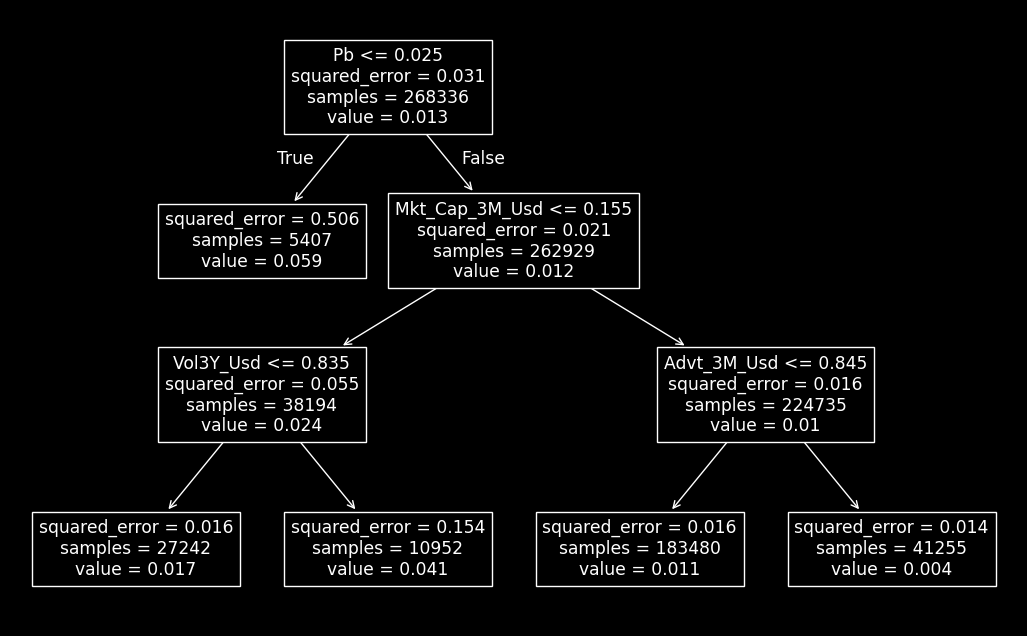

In [23]:
X = data_ml.iloc[:,3:96] # recall features/predictors, full sample
y = data_ml['R1M_Usd'] # recall label/Dependent variable, full sample

fit_tree = tree.DecisionTreeRegressor( # Definining the model
  min_samples_split = 8000, # Min nb of obs required to continue splitting 
  max_depth = 3, # Maximum depth (i.e. tree levels)
  ccp_alpha=0.000001, # complexity parameters
  min_samples_leaf =3500 # Min nb of obs required in each terminal node (leaf)
        )
fit_tree.fit(X, y) # Fitting the model
fig, ax = plt.subplots(figsize=(13, 8)) # resizing
tree.plot_tree(fit_tree,feature_names=X.columns.values, ax=ax) # Plot the tree
plt.show()

Below is conditional smoothing function of selected features

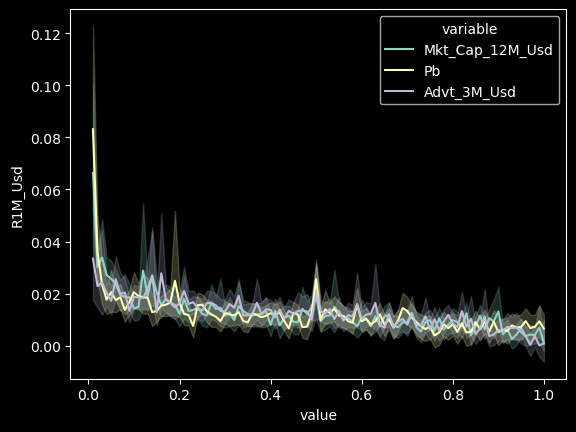

In [26]:
unpivoted_data_ml = pd.melt(data_ml[['R1M_Usd','Mkt_Cap_12M_Usd','Pb','Advt_3M_Usd']], id_vars='R1M_Usd') # selecting and putting in vector
sns.lineplot(data = unpivoted_data_ml, y='R1M_Usd', x='value', hue='variable'); # Plot from seaborn

Crate test and train data samples

In [59]:
# Define test and train data
separation_date = "2014-01-15"
training_sample = data_ml[(data_ml['date'] < separation_date)]
testing_sample = data_ml[(data_ml['date'] >= separation_date)]

Calculate prediction fit

In [67]:
y_train = training_sample['R1M_Usd'].values
X_train = training_sample[features].values
y_test = testing_sample['R1M_Usd'].values
X_test = testing_sample[features].values


fit_tree2 = tree.DecisionTreeRegressor( # Definining the model
  min_samples_split = 4000, # Min nb of obs required to continue splitting
  max_depth = 5, # Maximum depth (i.e. tree levels)
  ccp_alpha=0.0001, # complexity parameters
  min_samples_leaf =1500 # Min nb of obs required in each terminal node (leaf)
        )
fit_tree2 = fit_tree2.fit(X_train, y_train) # Fitting the model

mse = np.mean((fit_tree2.predict(X_test) - y_test)**2)
print(f'MSE: {mse}')
hitratio = np.mean(fit_tree2.predict(X_test) * y_test > 0)
print(f'Hit Ratio: {hitratio}')

MSE: 0.036996958091850045
Hit Ratio: 0.5460346399270738


## Random forests

Below random forests are implemented.

Also predictions on the first five sets of data have been calculated.

In [77]:
fit_RF = RandomForestRegressor(
    n_estimators=40, 
    criterion='squared_error',
    min_samples_split= 250, 
    bootstrap=True, 
    max_features=30,
    max_samples=10000
)

fit_RF.fit(X_train, y_train)
fit_RF.predict(pd.DataFrame(X_test).iloc[0:5,])

array([0.06716354, 0.07338199, 0.07750338, 0.06867893, 0.08021003])

In [80]:
mse=mean_squared_error(y_test, fit_RF.predict(X_test))
print(f'MSE: {mse}')
hitratio = np.mean(fit_RF.predict(X_test) * y_test > 0)
print(f'Hit Ratio: {hitratio}')

MSE: 0.03699390385015481
Hit Ratio: 0.5382719917958068


Below a random forrest classifier has been run which seeks to model categorical variables.

In [86]:
y_c_train = training_sample['R1M_Usd_C']
y_c_test = testing_sample['R1M_Usd_C']
fit_RF_C = RandomForestClassifier( 
n_estimators = 40,
criterion ='gini',
min_samples_split= 250,
bootstrap=True, 
max_features=30,
max_samples=20000 
)
fit_RF_C=fit_RF_C.fit(X_train, y_c_train) 

In [87]:
hitratio = np.mean(fit_RF_C.predict(X_test) == y_c_test)
print(f'Hit Ratio: {hitratio}')

Hit Ratio: 0.50078338650866
